In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4*4,4.8*1.5)

import numpy as np
from scipy import special

31.830988618379067
(20.0, 100.0)
9.396493890795204
3.0653701066584444


(0.0, 200.0)

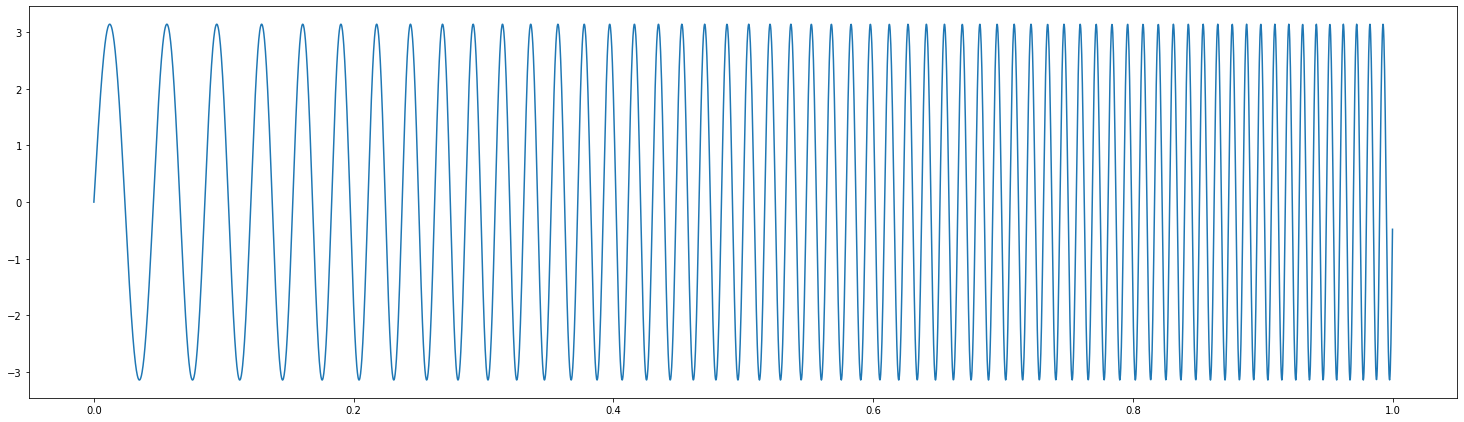

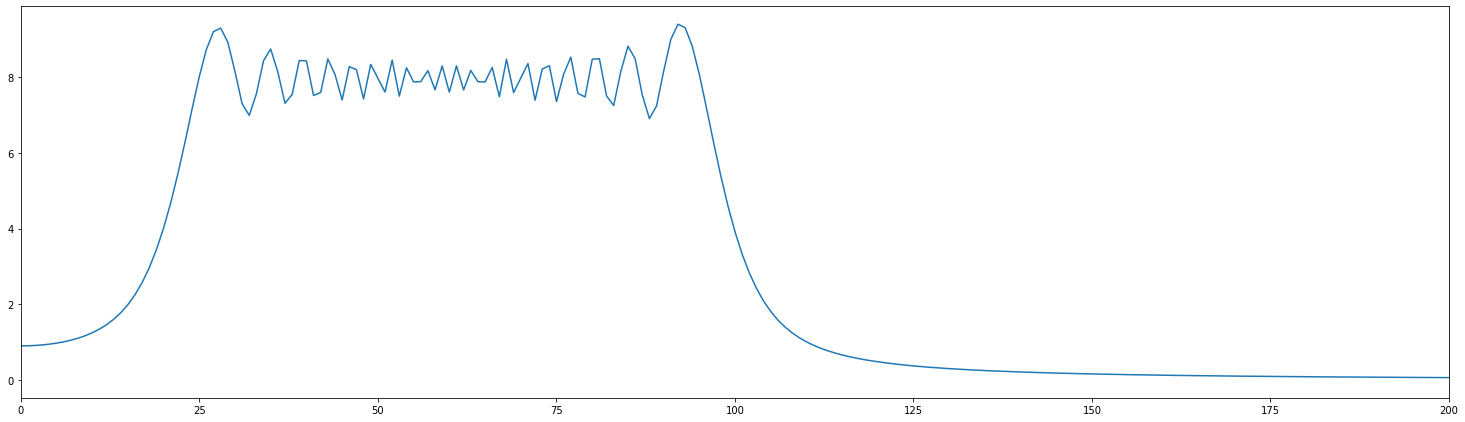

In [16]:
def swept_sine(f1: float, f2: float, Ts: float=1) -> None:
    ''' f1, f2, in Hertz
        TS in seconds
    '''

    # f0 is the minimum resolution
    f0 = 1 / Ts
    #assert f1 < fc and f2 < fc
    k1 = int(np.round(f1 / f0))
    k2 = int(np.round(f2 / f0))

    # k1 and k2 must be positive ints and > 1, otherwise the frequency resolution is not enough within the given time window
    # k2 > k1
    assert k1 > 1 and k2 > 1
    assert k2 > k1

    a = np.pi * (k2 - k1) * f0**2
    b = 2 * np.pi * k1 * f0

    # TODO: how many points are required to avoid freq domain aliasing?
    print(k2 * f0 / np.pi)
    # np.pi / N 
    N = 4096
    n = np.linspace(0, Ts, N, endpoint=False)

    f1 = k1 * f0
    f2 = k2 * f0
    return n, np.sin((a * n + b) * n), (f1, f2)


t, sig, freqs = swept_sine(20, 100, Ts=1)
sig = sig * np.pi
print(freqs)

smoother = 1
ffted = np.fft.rfft(sig, len(sig) * smoother, norm='ortho') / np.sqrt(2)
print(np.amax(np.abs(ffted)))
print(np.sqrt(np.amax(np.abs(ffted))))
plt.plot(t, sig)
plt.figure()
plt.plot(np.linspace(0, len(ffted) / smoother, len(ffted)), np.abs(ffted))
plt.xlim(0, 200)


In [17]:
def shroeder_multisine(f1, f2, Ts, F) -> None:
	# F is the number of distinct spectral lines
	f0 = 1 / Ts
	k1 = int(np.round(f1 / f0))
	k2 = int(np.floor(f2 / f0))

	fs = (k2 - k1) * f0 / F
	print(fs)

	assert fs > 1

	k = np.arange(k1, k2, fs)

	print(k1, k2)
	print(len(k))
	phases = -k * (k - 1)
	freqs =  k * fs
	Fs = int(round(k2 / fs))

	prezp = np.zeros(int(round(k1 / fs)))
	postzp = np.zeros(int(round(k2 / fs)))
	#positive_spectrum = list(prezp) + list(np.exp(1j * np.pi / Fs * (freqs + phases))) + list(postzp)
	positive_spectrum = list(prezp) + list(np.exp(1j * np.pi / Fs * (freqs + phases)))
	negative_spectrum = np.conj(np.flip(positive_spectrum))
	# create oscillator bank with dc value U[0] = 0
	U = np.array([0] + list(positive_spectrum) + list(negative_spectrum), dtype=np.complex128)

	# extract the continuous time domain signal corresponding to the constructed fourier series (hermitian spectrum)
	# norm of "ortho" applies a 1/sqrt(N) scaling, as desired
	u = np.fft.ifft(U, norm="ortho")
	return u, U


1.00354609929078
20 303
282


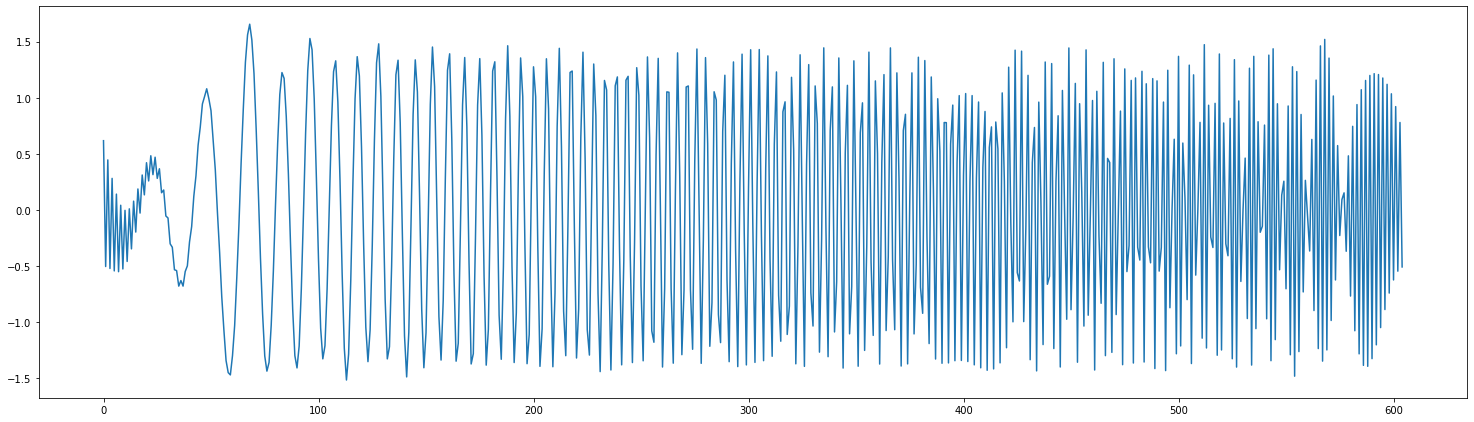

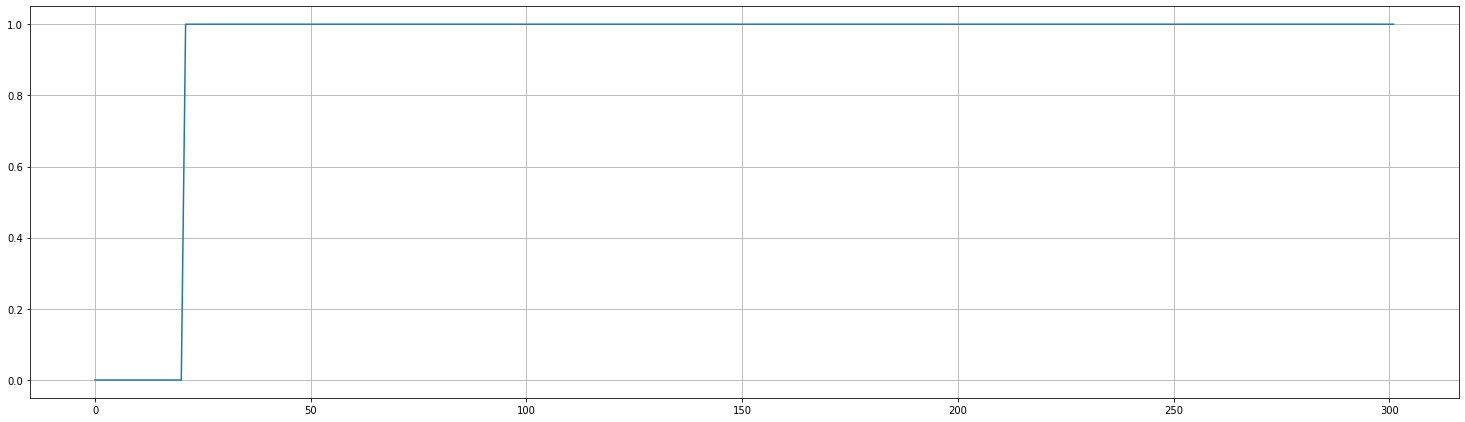

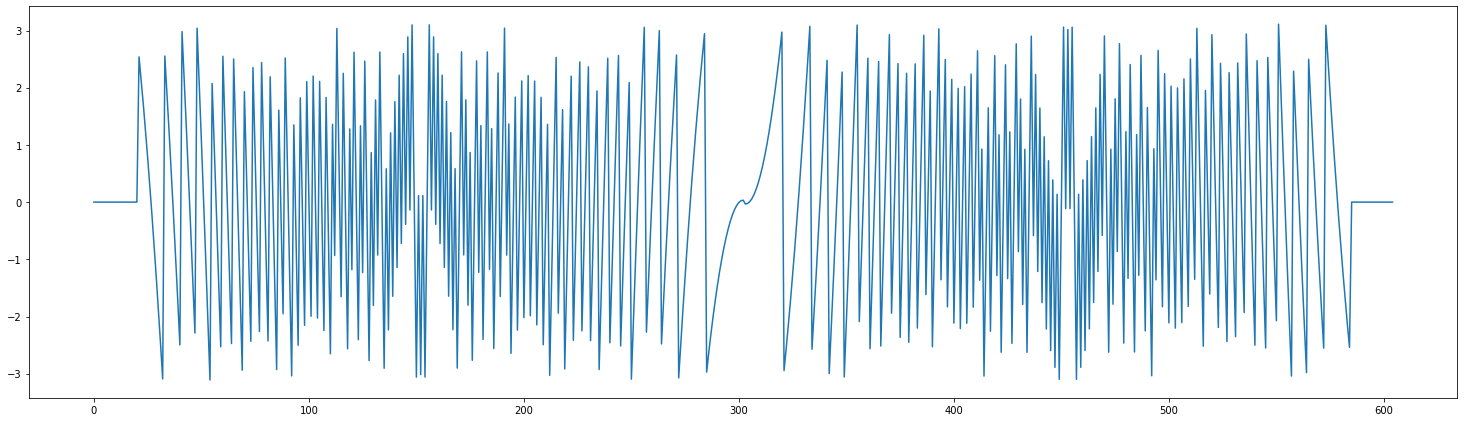

In [18]:
u, U = shroeder_multisine(20, 303, 1, 303-20-1)

#U = np.fftshift
plt.plot(np.real(u))
plt.figure()
plt.plot(np.abs(U[:len(U)//2]))
#plt.xlim(0, 350)
plt.grid()
plt.figure()
plt.plot(np.angle(U))

In [19]:
def write_to_c_array(data, holdcount=1):
    tablefile = open("table.c", "w")
    tablefile.write("#include <stdint.h>\n\n")
    tablefile.write(f'unsigned DRIVE_LUT_SIZE = {len(data) * holdcount};\n')
    tablefile.write(f'uint16_t DRIVE_LUT[{len(data) * holdcount}] = {"{"} \\')
    for index in np.arange(len(data)):
        val = data[index]
        chunk = holdcount * f'{int(val)},'
        if index % 32:
            tablefile.write(chunk)
        else:
            tablefile.write(f'\n{chunk}')
    tablefile.write("\n};")
    tablefile.close()

In [20]:
def periodic_noise(N, P=1, gain=1, fs=1, process=None):
    if process is None:
        process = np.random.default_rng(123)

    k = process.integers(low=1, high=N, size=N-1)
    U = np.zeros(N * 2, dtype=np.complex128)

    # signal is real, so its spectrum is hermitian (negative frequencies are conjugate symmetric)
    samples = k / N * gain * np.exp(1j * 2 * np.pi * k / N)
    # create oscillator bank with dc value U[0] = 0
    U[1:N] = samples

    # create time domain signal
    u = 2 * np.sqrt(UNITY_AMPLITUDE) * np.real(np.fft.irfft(U))
    return u, U[:N]


In [21]:
def random_phase_multisine(N, P=1, gain=1, fs=1, process=None):
    '''
        N: number of "time samples" in one signal period

        P: number of time domain periods to generate

        With a normalized amplitude spectrum, the DFT coefficient magnitudes U(k*fs/N) are scaled by 1/sqrt(N)
        U(k*fs/N) are uniformley bounded with a finite number of discontinuities on [0, fs/2].
        Further, the clock frequency fs is independent of N.

        Phase mean drawn from the random process must = 0
    '''

    # spectral resolution = 2*pi / N

    # F is the number of unique spectral lines between [0, fs/2)
    if process is None:
        process = np.random.default_rng()

    # N is even
    # results in N2 number of "real" spectral lines, but we later set dc component to 0
    N2 = (N - 1) // 2
    # sample positive frequencies up to fs, skipping dc
    k = process.integers(low=1, high=N, size=N2)

    # signal is real, so its spectrum is hermitian
    # negative frequencies are conjugate symmetric
    # magnitude is even while the phase is odd
    positive_spectrum = np.exp(1j * 2 * np.pi * k / N)
    print(len(positive_spectrum))
    negative_spectrum = np.conj(np.flip(positive_spectrum))
    # create oscillator bank with dc value U[0] = 0
    U = np.array([0] + list(positive_spectrum) + list(negative_spectrum), dtype=np.complex128)
    Ur = [1] + list(positive_spectrum)
    Ur = np.fft.fftshift(Ur)
    ur = np.fft.irfft(Ur, norm="ortho")

    # extract the continuous time domain signal corresponding to the constructed fourier series (hermitian spectrum)
    # norm of "ortho" applies a 1/sqrt(N) scaling, as desired

    U = np.fft.fftshift(U)
    u = np.fft.ifft(U, norm="ortho")
    return u, U, ur, Ur

126
253
253
phase[dc]=0.0
phase[fs/2]=-0.2731819698773734


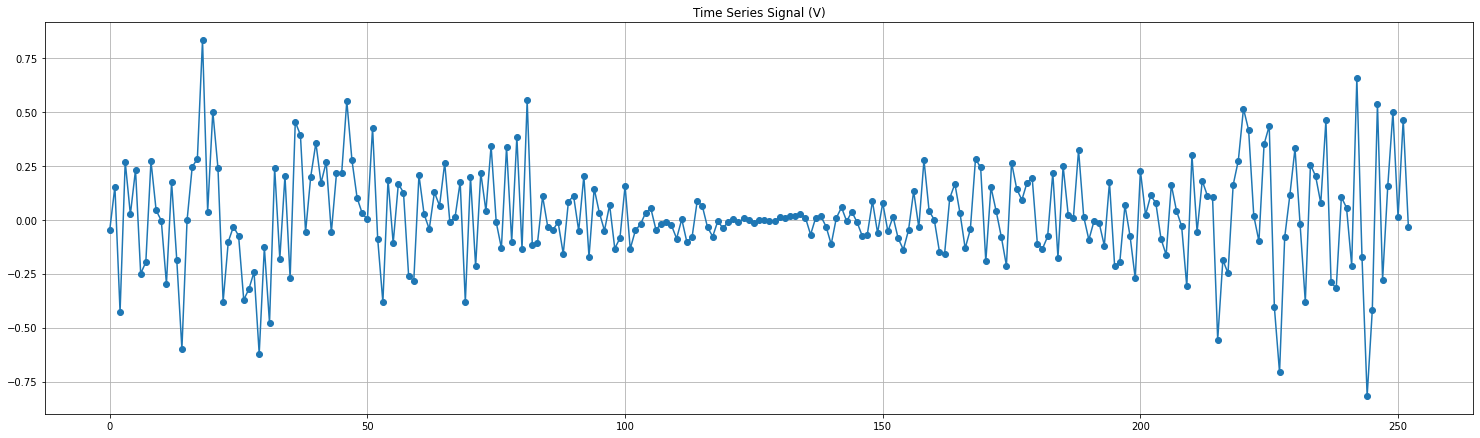

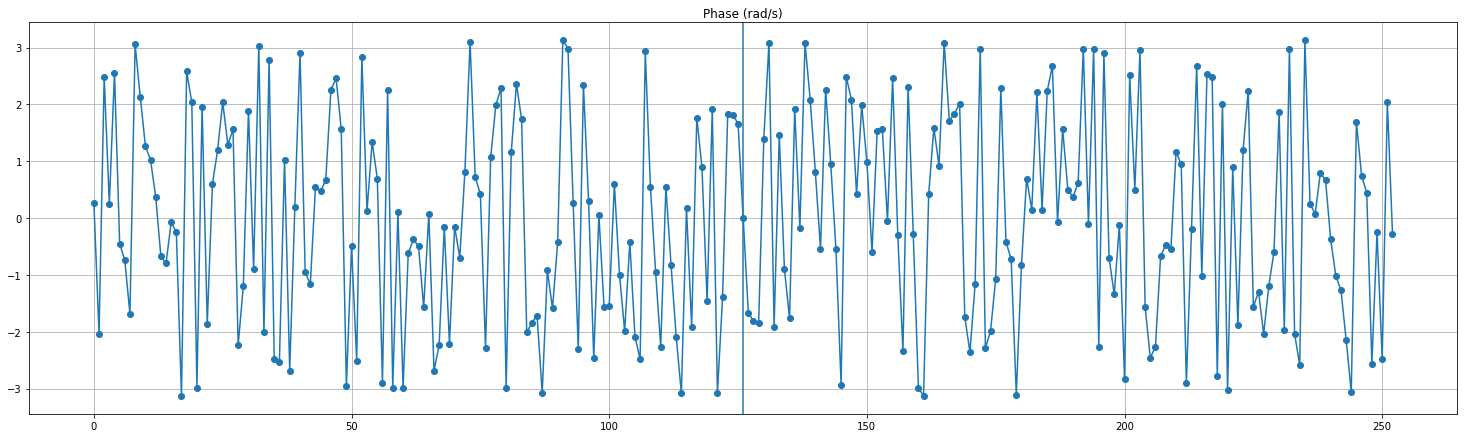

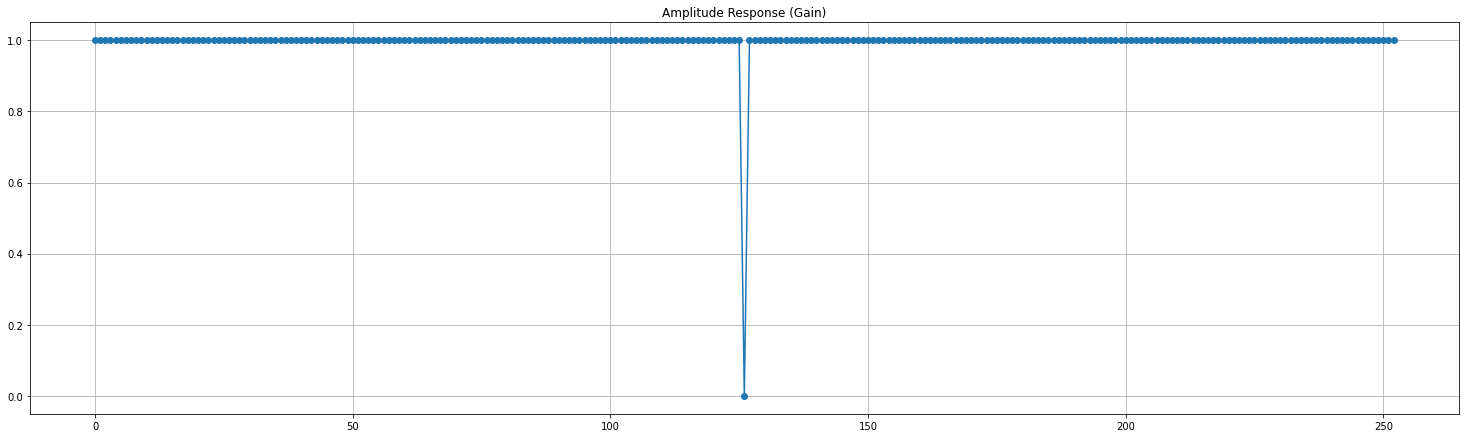

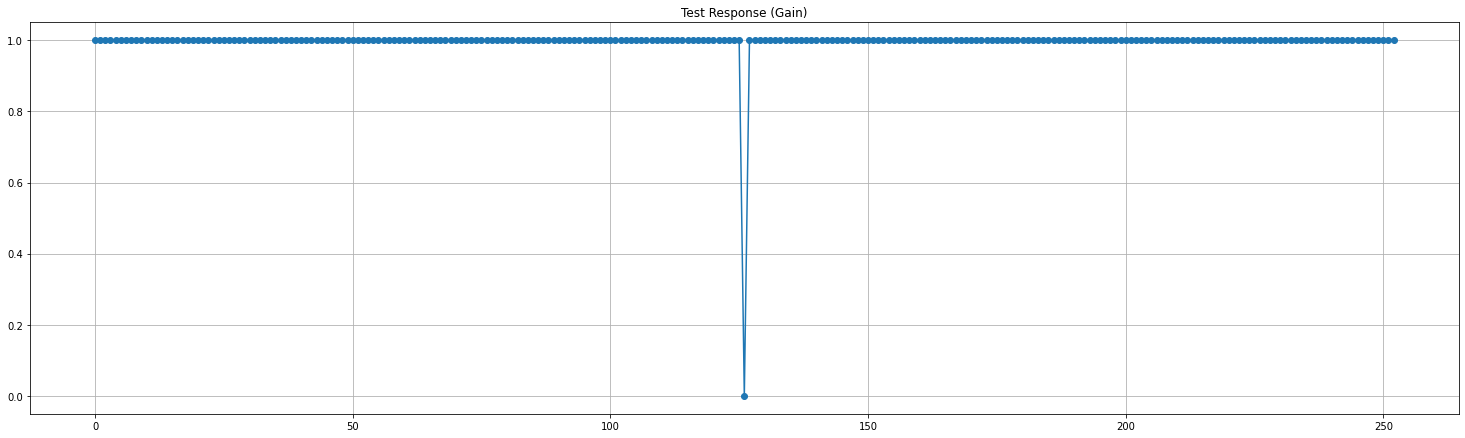

In [22]:
N = 253
u, U, _, _ = random_phase_multisine(N=N)
# the exact coordinate transformation is 2 * np.real(u)
# here we normalize to 1 instead of 2*pi
ureal = np.real(u) / np.pi
(print(len(U)))
print(len(u))

plt.figure()
plt.grid()
plt.title('Time Series Signal (V)')
plt.plot(ureal, marker='o')

plt.figure()
plt.grid()
plt.title('Phase (rad/s)')
checkfft = np.fft.fft(u, norm="ortho")
phase = np.angle(U)#np.angle(checkfft)
print(f'phase[dc]={phase[len(phase)//2]}')
print(f'phase[fs/2]={phase[-1]}')
plt.plot(phase, marker='o')
plt.axvline(x=len(phase) // 2)

plt.figure()
plt.grid()
plt.title('Amplitude Response (Gain)')
plt.plot(np.abs(U), marker='o')

plt.figure()
plt.grid()
plt.title('Test Response (Gain)')
plt.plot(np.abs(checkfft), marker='o')

#plt.figure()
#plt.grid()
#plt.title('Magnitude Response (dB)')
#mag = 20 * np.log10(np.nan_to_num(np.abs(U)))
#plt.bar(np.arange(len(mag)), mag)


506


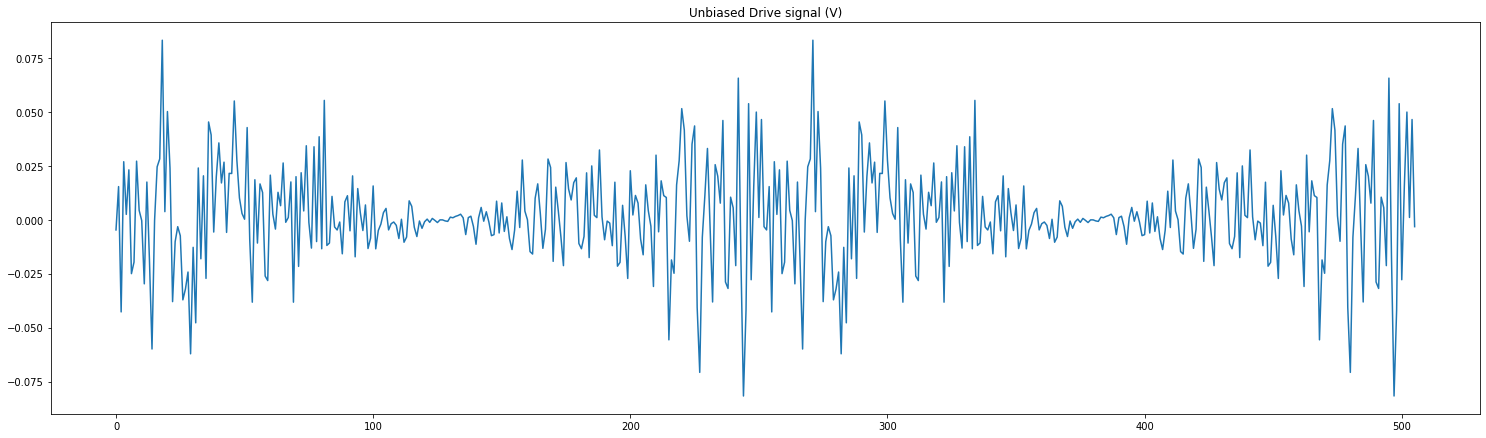

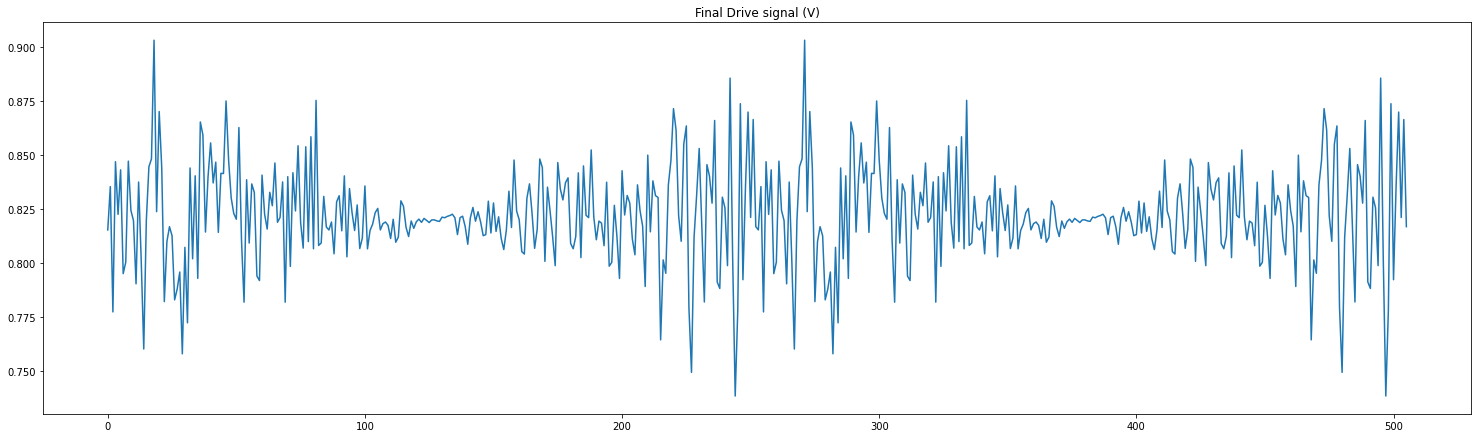

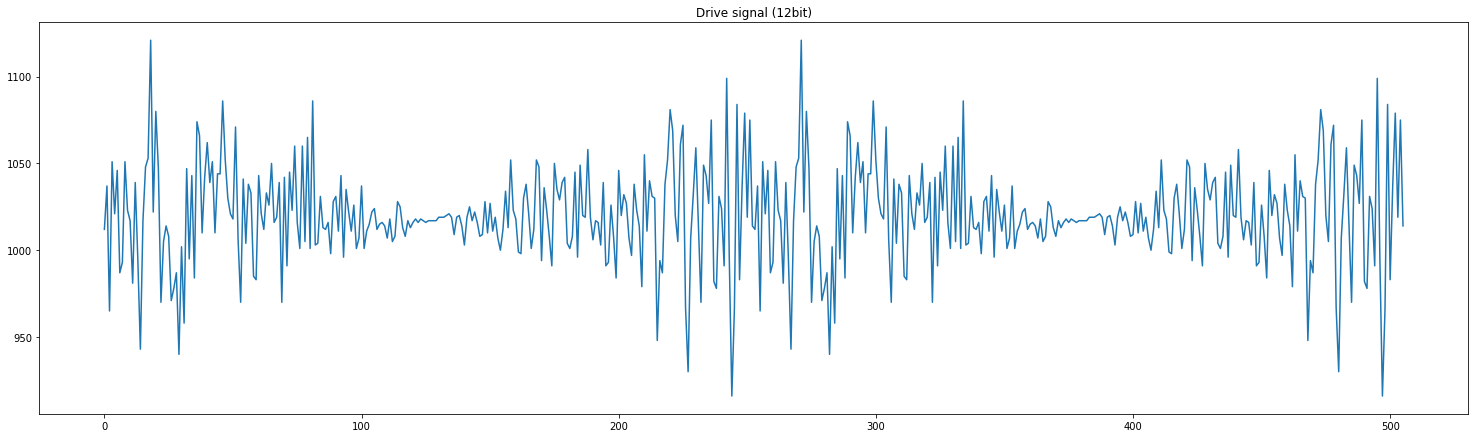

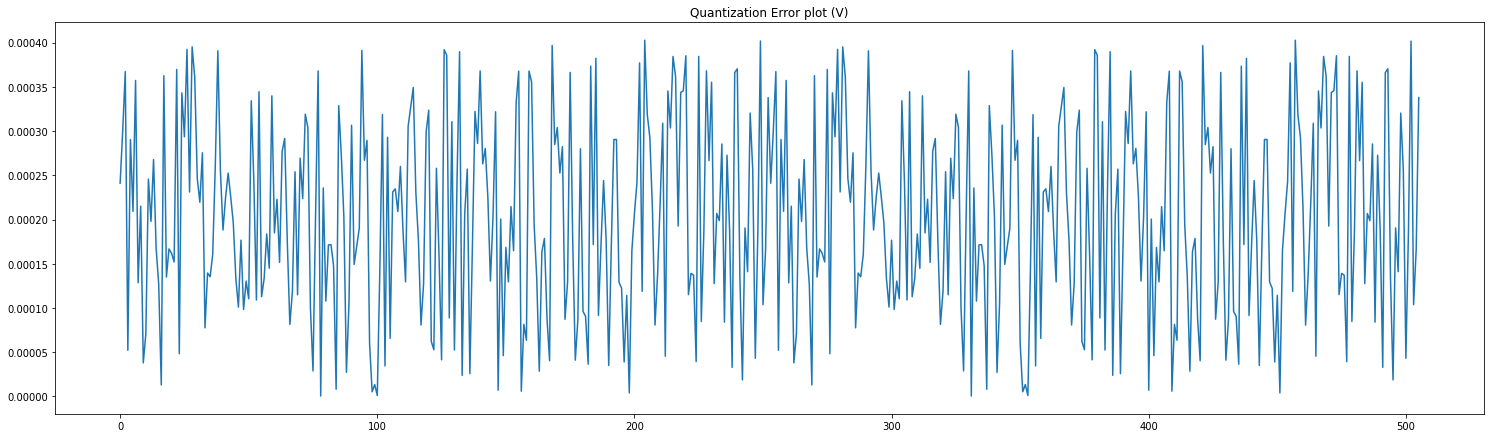

In [23]:

# transform to be output ready
u_out = ureal.copy()

u_out *= UNITY_AMPLITUDE

u_out = np.concatenate((u_out, u_out))
print(len(u_out))
plt.figure()
plt.title('Unbiased Drive signal (V)')
plt.plot(u_out)
u_out += BIAS
plt.figure()
plt.title('Final Drive signal (V)')
plt.plot(u_out)

dac_table = np.round(u_out * 4095 / 3.3)
plt.figure()
plt.title('Drive signal (12bit)')
plt.plot(dac_table)

plt.figure()
plt.title('Quantization Error plot (V)')
plt.plot(np.abs(dac_table * 3.3 / 4095 - u_out))

#write_to_c_array(dac_table, holdcount=1)
